# DataLab Cup 2: CNN for Object Detection

In [ ]:
import tensorflow as tf
import numpy as np

from data_aug.data_aug import *
from data_aug.bbox_util import *

# Setup GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        # for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


# Hyperparameters

In [ ]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 1
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 10

# Data Augmentation

- 我們發現此次的data非常imbalanced，標記最多的前三類別分別為person(14)有多達5318個標記，car(6)有1634個標記，chair(8)有1423個標記，他們的數量遠遠大於其他17項類別(平均約只有414個標記)，其中數量最少的項目為bus(5)甚至只有271個標記，因此我們透過針對標記類別較少的圖片做augmentation來解決資料不平衡的問題。

- augmentation的部分是採用github上現成的方法作為API，當中提供了機率的條件來增加生成圖片的隨機性。

- augment形式有以下四種:
    - 改變 HSV 值 (即色相、飽和度、明度)
    - HorizontalFlip
    - scale
    - shear

- 如上所說，person、car、chair這些類別的資料量已經很多了，因此主要會針對數量較少的類別來增加圖片的數量，最後我們讓每個類別的數量平均在2000左右，以達到平衡資料的目的。在實驗上對performance也確實有蠻顯著的提升。

In [ ]:
image_names = []
record_list = []
object_num_list = []
# filling the record_list
input_file = open(DATA_PATH, 'r')

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    image_names.append(ss[0])

    record_list.append([float(num) for num in ss[1:]])

    object_num_list.append(min(len(record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
    if len(record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1] +\
        [0., 0., 0., 0., 0.]*\
        (MAX_OBJECTS_PER_IMAGE-len(record_list[-1])//5)
    elif len(record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
        
# update bounding box 成 配合API的 
# "左上(xmin, ymax), 右下(xmax, ymin)兩點座標 及 label"
def update_bboxes(bbox):

    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    label = bbox[4]
    
    return [xmin,ymax,xmax,ymin,label]

# 判斷object是什麼
# object_class = [[8, 8, 8, 8, 8], [6], ...]
object_class = []
for i in range(len(record_list)):
    object_class2 = []
    k = 4
    for j in range(object_num_list[i]):
        object_class2.append(str(int(record_list[i][k])))
        k += 5
    object_class.append(object_class2)
    

# 得到bounding box
bboxes_list_raw = []
for i in range(len(record_list)):
    count = 0
    bboxes = []
    for j in range(int(len(record_list[i])/5)):
        bboxes.append(record_list[i][count:count + 5])
        count += 5
    
    # [xmin, ymin, xmax, ymax, label] -> [xmin, ymax, xmax, ymin, label]
    bboxes = np.array([update_bboxes(k) for k in bboxes])
    bboxes_list_raw.append(bboxes)

bboxes_list_raw = dict(zip(image_names,bboxes_list_raw))
# bboxes_list_raw

- 這部分定義了是否要做augmentation、以及要增加張數的條件，條件中的6, 8, 14即前面提到資料量較多的類別(car, chair, person)，會避免再過度增加這類的資料量; 反之針對資料量較少及AP較低的類別加強生成，根據我們判斷出來需要加強生成的條件，共分成5個級別 (生成20張、15張、10張、4張、0張)。

In [ ]:
def counter_for_10(object_list):
    # print(object_list) # [8, 8, 8, 8, 8]
    object_strongaug_aug = sum([(i == '10') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 1
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_for_special(object_list):
    object_strongaug_aug = sum([(i == '1' or i == '10' or i == '12' or i == '13' or i == '5') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_element_strong(object_list):
    # 8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '8' or i == '6' or i == '14') for i in object_list]) > 0
    if object_no_aug:
      return False
    else:
      return True

def counter_element(object_list):

    # 非14,非8,非6的物件(需要aug的為0)
    object_need_aug = sum([(i != '14' and  i != '8' and i != '6') for i in object_list]) == 0
    # 14,8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    # 14是否過多
    object_much_14 = sum([i == '14' for i in object_list]) > 0

    if (object_need_aug and object_need_aug) or object_much_14:
        return False
    else:
        return True

In [ ]:
# aug img name list
aug_names = []

# 範例名稱為 aug_0_00001.jpg, aug_1_00001.jpg, aug_2_00001.jpg
for i in range(int(len(object_class))):
    if counter_for_10(object_class[i]):
        for j in range(20):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_for_special(object_class[i]) == True:
        for j in range(15):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element_strong(object_class[i]) == True:
        for j in range(10):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element(object_class[i]) == True:
        for j in range(4):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    else:
        aug_names.append("aug" + "_" + '0' + "_" + image_names[i])

Augmentation parameter 部分

In [ ]:
np.random.seed(77)

# 改變 HSV
H = np.random.randint(60,size = len(aug_names))
S = np.random.randint(60,size = len(aug_names))
V = np.random.randint(60,size = len(aug_names))

# 改變 HorizontalFlip
flip = np.random.binomial(1, 0.5, len(aug_names))

# 改變 Scale
scale1 = np.random.uniform(-0.15,0.15,len(aug_names))
scale2 = np.random.uniform(-0.15,0.15,len(aug_names))

# 改變 Shear
shear = np.random.uniform(-0.15,0.15,len(aug_names))
random_parameter = dict(zip(aug_names,list(zip(H,S,V,flip,scale1,scale2,shear))))
image_object_dict = dict(zip(image_names,object_num_list))

# Dataset Loader
生成 balanced 的 dataset，如名稱中的數量為0表示為原圖不需要生成，其他為依序生成的index: (範例如下)
  - aug_0_00001.jpg (原圖)
  - aug_1_00001.jpg (生成圖片1)
  - aug_2_00001.jpg (生成圖片2)


In [ ]:
# Balanced 的 data generater
def get_balance_augmentation():
    #count = 0
    for count in range(len(aug_names)):
        aug_name_list = aug_names[count].split('_')
        object_num = image_object_dict.get(aug_name_list[2])

        # 若 idx 為 0 則生成原圖
        if aug_name_list[1] == "0":
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            
            count +=1
            
        # 否則開始生成 augmentation 過的圖片
        else:
            parameter = random_parameter.get(aug_names[count])
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            seq = Sequence([RandomHSV((parameter[0],parameter[0]), (parameter[1],parameter[1]), (parameter[2],parameter[2])),
                            RandomHorizontalFlip(parameter[3]), Scale(parameter[4],parameter[5]), Shear(parameter[6])])
            img, bboxes = seq(img.numpy().copy(), bboxes.copy())
            
        if bboxes.shape[0] != 20:
            bboxes = np.concatenate([bboxes,np.zeros((20 - bboxes.shape[0] ,5))],axis = 0)
            
            count +=1
            
        # map function
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]
        
        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 
        
        image = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        # image = tf.keras.applications.vgg16.preprocess_input(image) # vgg16的preprocess
        image = tf.keras.applications.densenet.preprocess_input(image) # denseNet121 的preprocess

        
        # raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        raw_labels = tf.cast(bboxes, tf.float32)
        
        # 為了不讓bboxes的數值超出範圍，對bboxes range做一個修正。
        xmin = raw_labels.numpy()[:, 0]
        xmin[xmin > w.numpy()] = w.numpy()
        
        ymax = raw_labels.numpy()[:, 1]
        ymax[ymax > h.numpy()] = h.numpy()
        
        xmax = raw_labels.numpy()[:, 2]
        xmax[xmax > w.numpy()] = w.numpy()
        
        ymin = raw_labels.numpy()[:, 3]
        ymin[ymin > h.numpy()] = h.numpy()
        
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate
        
        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)
        
        # BBOXES做過濾，以免BBOXES超出邊界。
        if ((xcenter.numpy()[:object_num] > 447.5).sum() + (ycenter.numpy()[:object_num] > 447.5).sum()) > 0:
            continue   

        if ((box_w.numpy()[:object_num] < 0.5).sum() + (box_h.numpy()[:object_num] < 0.5).sum()) > 0:
            continue
            
        if np.any((xcenter - box_w/2) < 0):
            continue
        
        if np.any((ycenter - box_h/2) < 0):
            continue
        
        if np.any((xcenter + box_w/2) > 500):
            continue
        
        if np.any((ycenter + box_h/2) > 500):
            continue
    
    
        yield image, labels, tf.cast(object_num,tf.int32)

# Tensorflow dataset
dataset = tf.data.Dataset.from_generator(get_balance_augmentation,
                                         (tf.float32, tf.float32,tf.int32),
                                         (tf.TensorShape([448,448,3]),tf.TensorShape([20,5]),tf.TensorShape([])))
dataset = dataset.shuffle(2000)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=200)

In [ ]:
# data_generator = get_balance_augmentation()

# Model

---
### Transfer Leaning - Feature Extractor Selection

- 在模型的選擇上本該有很多，如做 `TransferLearning` 或者直接整個架構直接換成別的寫法。
- 本來的目標架構例如 **YOLOv3, Faster-RCNN, EfficientDet, RetinaNet, SSD**等。
- 但由於我們在時間和技術上的限制，最後只選擇了使用 `TransferLearning` ， 首先是以 `Tensorflow` 中已經pretrained好的weight的模型來當做Feature Extractor來測試。以下是測試的分類表現，皆基於YOLOv1的 `classfier`：

  *   Level1: VGG16, VGG19, Xception, ResNet50,101,152, ResNet_v2, InceptionResNet_v2
  *   Level2: EfficientNet, EfficientNet B5, B7
  *   Level3: DenseNet121 (Best Performance), DenseNet 169, 201

- Level1的模型對於分類和框的準確率都相當底； Level2的模型都可以做到一定程度的分類但是框會偏大， Level3的 `DenseNet` 系列的模型對於分類和detect框都是在這些模型中有最好表現的。

- 整體效果會比較差是可以理解的，畢竟這些模型本來是專門在做 `feature extract` 和 `classify` 的(在最後的成果上，模型的classify的能力的確是比只使用YOLOv1的效果來得好)， 如果要達到很好的效果還是要選擇 `segmentation` 比較敏感，才可以達到 `multiple object detection` 優良的表現。

---

### Feature Extractor Tuning - Unfreeze Weight & re-Train

- 在選了`DenseNet121`做為backbone後，我們還試著對FE模型做一些tuning，例如`unfreeze` DenseNet最後一個block的layers，並重新train看看，想說可以讓FE更貼近Classfier的行為表現。
- 這裡的tuning我們有做了兩者方式的嘗試，分別是一開始就unfreeze最後一個block後就一路train到結束；另一種是前幾個epoch不unfreeze，用原本的pretrained weight，到了一定程度epoch數後才解開weight再train。但是不管兩者的表現怎麼樣都對提升`boundingBox`框的準確率沒有太大的提升，也許是根本上的模型就不適合做這種行為，所以unfreeze weight的效果就沒有那麼明顯。

---

### Classfier Tuning - Add BatchNormalization, DropOut

- 除了對FE做處理，`classfier`也可以tuning。我們打算加入`BatchNormalization`和`DropOut`到`Conv_Leaky_ReLU`的block中。
- 選擇`BN`是因為受到`YOLOv2`的啟發， 發現加入BN可以改進一些performance。
- 選擇`DropOut`目的是為了使模型更generalize一點，增加泛化能力。

以上詳細的表現會在接下來的cell展現，以及在Notebook最後的`Performance Analysis`做總結。

## YOLOv1

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    # x = layers.Dropout(0.2)(x)

    return x

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")
YOLO.summary()

## DenseNet + YOLOv1_Classifier

In [ ]:
# ResNet121
# IMAGE_SIZE = 448
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet',classes=20)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470)(x)

DenseNet121 = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
DenseNet121.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 14, 14, 1024)      7037504   
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 1024)      9438208   
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 1024)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 1024)      9438208   
                                                       

## YOLOv3 (Darknet53 as backbone)
YOLO v3 uses a variant of Darknet, which originally has 53 layer network trained on Imagenet. For the task of detection, 53 more layers are stacked onto it, giving us a 106 layer fully convolutional underlying architecture for YOLO v3. Original YOLO v3 outputs 3 scales of feature map, which is dirrerent from our model (dense layer with 1470 neurons in the last layer). We adapt model a little to correspond to ours(describe below). 

In [ ]:
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import Flatten, Dense
from keras.layers.merge import add, concatenate

# define a basic convolution block
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

In [ ]:
def build_YOLOv3(input):
	"""
	First 53 layers is Darknet backbone, YOLO v3 has total 106 layers.
	"""
	input_image = input
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

	"""
	Following part is defined to correspond to our original output specification.
	We flattened different feature maps with differen scale and connect to its dense layer respectively.
	Then, concatenate all feature with different scale and pass to two dense layers to get final prediction.
	"""
	sx = Flatten()(yolo_82)
	mx = Flatten()(yolo_94)
	lx = Flatten()(yolo_106)

	sx = Dense(512)(sx)
	sx = LeakyReLU(0.1)(sx)
	mx = Dense(512)(mx)
	mx = LeakyReLU(0.1)(mx)
	lx = Dense(512)(lx)
	lx = LeakyReLU(0.1)(lx)
	
	x = concatenate([sx, mx, lx])
	x = Dense(1024)(x)
	x = LeakyReLU(0.1)(x)
	outputs = Dense(1470)(x)

	return outputs

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
outputs = build_YOLOv3(img_inputs)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLOv3")
model.summary()

YOLOv3是一個強大的Object Detection Model，不過最後訓練出來的結果並不理想，我們推測有兩個原因。<br>
1. 我們這次的實驗中為了將output與原先資料格式對齊，而在最後加了幾層layers將不同尺寸的feature map混合，可能失去了原本YOLOv3想要訓練出來的目的，也有可能是我們後續處理的layer不太好。
2. 在Darknet backbone中我們實現了他的架構，但並沒有找到合適的resource套入預訓練在Imagenet上的權重，這應該會對performance有顯著的影響。

# Define loss

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

# Training

In [ ]:
# dataset = DatasetGenerator().generate()

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=DenseNet121)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = DenseNet121(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, DenseNet121.trainable_weights)
    optimizer.apply_gradients(zip(grads, DenseNet121.trainable_weights))

In [ ]:
from datetime import datetime

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2021-11-25 15:18:49.714488, start training.


/home/gary/DL_course/Deep-Learning-Course-Team-Project/Competition 2/data_aug/bbox_util.py:83: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


2021-11-25 15:47:31.801502, Epoch 1: loss 7.07
Saved checkpoint for epoch 1: ./ckpts/YOLO/yolo-1
2021-11-25 16:16:10.060786, Epoch 2: loss 4.15
Saved checkpoint for epoch 2: ./ckpts/YOLO/yolo-2
2021-11-25 16:44:47.877827, Epoch 3: loss 3.51
Saved checkpoint for epoch 3: ./ckpts/YOLO/yolo-3
2021-11-25 17:13:24.927812, Epoch 4: loss 3.12
Saved checkpoint for epoch 4: ./ckpts/YOLO/yolo-4
2021-11-25 17:42:05.063603, Epoch 5: loss 2.96
Saved checkpoint for epoch 5: ./ckpts/YOLO/yolo-5
2021-11-25 18:10:44.636930, Epoch 6: loss 2.80
Saved checkpoint for epoch 6: ./ckpts/YOLO/yolo-6
2021-11-25 18:39:24.584465, Epoch 7: loss 2.70
Saved checkpoint for epoch 7: ./ckpts/YOLO/yolo-7
2021-11-25 19:08:01.242753, Epoch 8: loss 2.62
Saved checkpoint for epoch 8: ./ckpts/YOLO/yolo-8
2021-11-25 19:36:38.496329, Epoch 9: loss 2.59
Saved checkpoint for epoch 9: ./ckpts/YOLO/yolo-9
2021-11-25 20:05:15.634019, Epoch 10: loss 2.55
Saved checkpoint for epoch 10: ./ckpts/YOLO/yolo-10


# Testing

- 在predict bounding box的部分, 原本只取confidence最大的那個box, 但ground truth當中很多都是不只有一個object, 所以model勢必要能夠output多個bounding boxes<br>
- 所以我們將原本要回傳的變數都變成list, 並設定一個threshold來把超過threshold的confidence的物件都predict出來, 並去記錄一共有幾個物件被predict出來

In [ ]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    # -------------modify-------------
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    class_num = []
    max_conf = []
    max_conf.append(np.max(P))
    index = np.argmax(P)
    index = np.unravel_index(index, P.shape)
    # print(max_conf, P[index]) max_conf == P[index]

    # class_num.append(index[3])

    # coordinate = np.reshape(coordinate, 
    #                         (CELL_SIZE, 
    #                          CELL_SIZE,
    #                          BOXES_PER_CELL, 
    #                          4))

    # max_coordinate = coordinate[index[0], index[1], index[2], :]

    # xcenter = max_coordinate[0]
    # ycenter = max_coordinate[1]
    # w = max_coordinate[2]
    # h = max_coordinate[3]

    # xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    # ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    # w = w * IMAGE_SIZE
    # h = h * IMAGE_SIZE

    # xmin.append(xcenter - w/2.0)
    # ymin.append(ycenter - h/2.0)

    # xmax.append(xmin[0] + w)
    # ymax.append(ymin[0] + h)


    threshold = P[index] * 0.5

    # box_per_grid = 0
    num_of_pred_box = 0
    for i in range(1570):
        idx = np.unravel_index(i, P.shape)
        if(P[idx] > threshold):
            # box_per_grid += 1
            max_conf.append(P[idx])
            class_num.append(idx[3])

            coordinate = np.reshape(coordinate, 
                                    (CELL_SIZE, 
                                    CELL_SIZE,
                                    BOXES_PER_CELL, 
                                    4))

            max_coordinate = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = max_coordinate[0]
            ycenter = max_coordinate[1]
            w = max_coordinate[2]
            h = max_coordinate[3]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin.append(xcenter - w/2.0)
            ymin.append(ycenter - h/2.0)

            xmax.append(xmin[num_of_pred_box] + w)
            ymax.append(ymin[num_of_pred_box] + h)
            num_of_pred_box += 1
    # print(box_per_grid)

    return xmin, ymin, xmax, ymax, class_num, max_conf, num_of_pred_box # -------------modify-------------

In [ ]:
test_img_files = open('./dataset/pascal_voc_testing_data.txt')
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

## Restore model weight checkpoints

In [ ]:
ckpt = tf.train.Checkpoint(net=DenseNet121)
ckpt.restore('./ckpts/YOLO/yolo-10')

In [ ]:
@tf.function
def prediction_step(img):
    return DenseNet121(img, training=False)

## Make prediction and output to txt file

在寫入output file時, 藉由額外的for loop來將剛剛記錄的object predict數量一一寫回

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # -------------modify-------------
        xmin, ymin, xmax, ymax, class_num, conf, num_of_pred_box = process_outputs(prediction_step(test_img[i:i+1]))
        for j in range(num_of_pred_box):
            xmin[j], ymin[j], xmax[j], ymax[j] = xmin[j]*(img_w[i:i+1]/IMAGE_SIZE), ymin[j]*(img_h[i:i+1]/IMAGE_SIZE), xmax[j]*(img_w[i:i+1]/IMAGE_SIZE), ymax[j]*(img_h[i:i+1]/IMAGE_SIZE)
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))
        # -------------modify-------------

output_file.close()

## Run evaluation metric

In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

In [ ]:
all_boudingBoxes, big_boundingBoxes = evaluate.evaluate('./test_prediction.txt', './output_file.csv')

## Print all the Average Precision result through all classes in group 8

- for evaluate model performance 

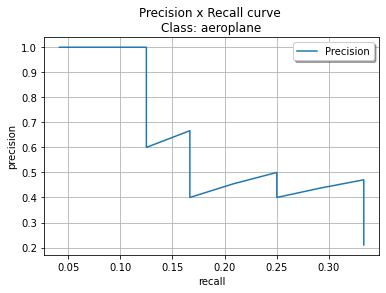

Average Precision:  0.23366013071895422


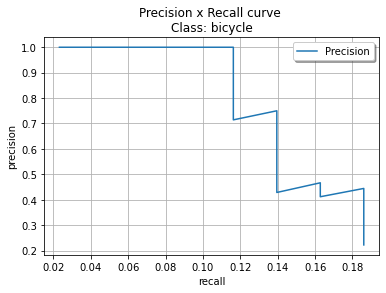

Average Precision:  0.1549095607235142


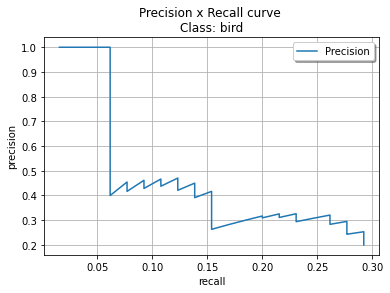

Average Precision:  0.1472212173070853


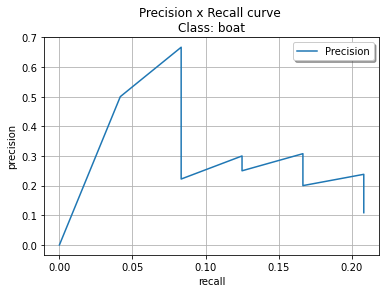

Average Precision:  0.09111721611721611


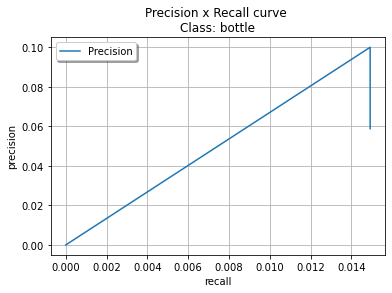

Average Precision:  0.0014925373134328358


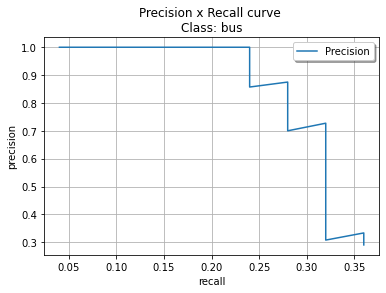

Average Precision:  0.3174242424242424


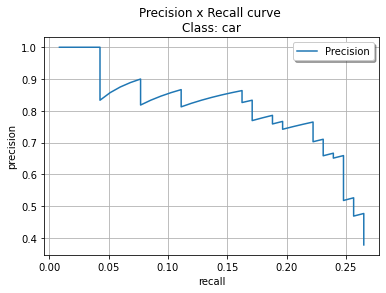

Average Precision:  0.2201158446574022


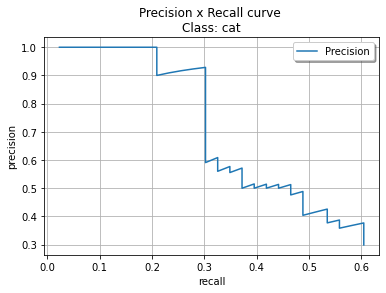

Average Precision:  0.44204763204783687


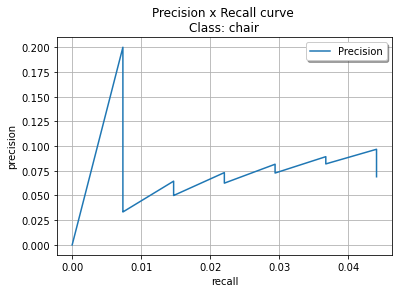

Average Precision:  0.005028462998102466


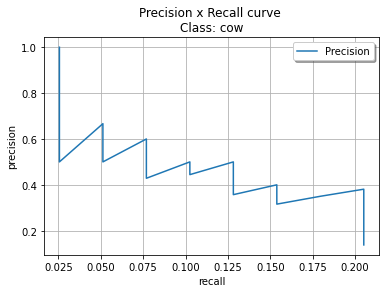

Average Precision:  0.11355311355311354


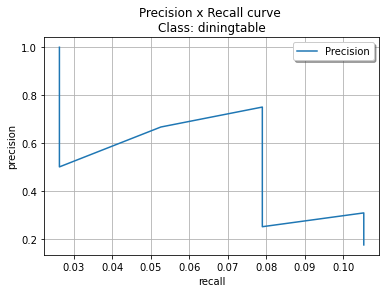

Average Precision:  0.07388663967611336


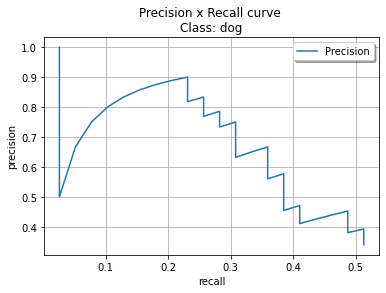

Average Precision:  0.3769023585765667


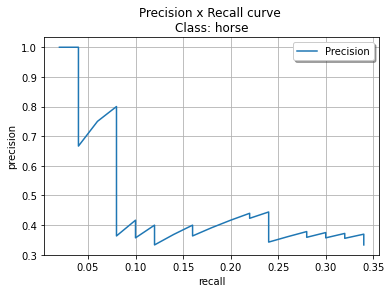

Average Precision:  0.1805794110591886


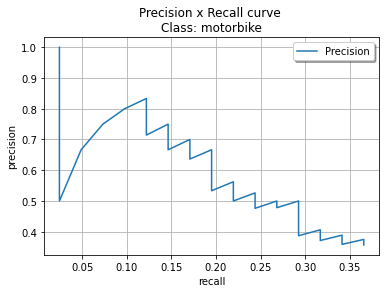

Average Precision:  0.23680377264298957


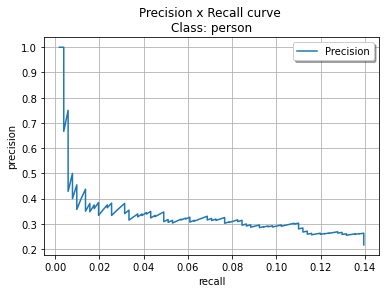

Average Precision:  0.04907495261136934


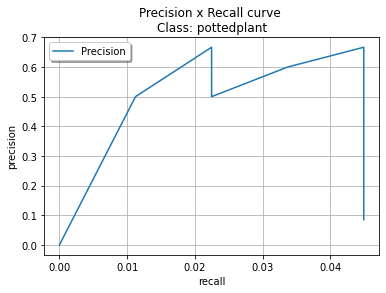

Average Precision:  0.029962546816479398


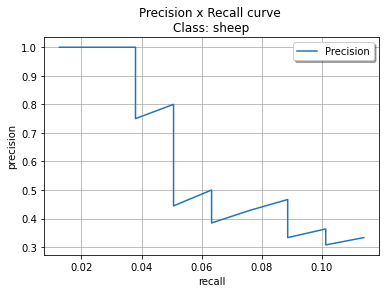

Average Precision:  0.07506712696586115


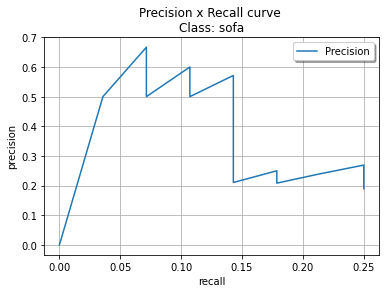

Average Precision:  0.11830193615907901


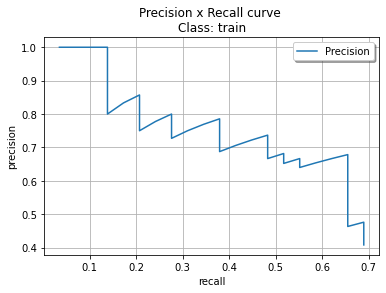

Average Precision:  0.5432499744659455


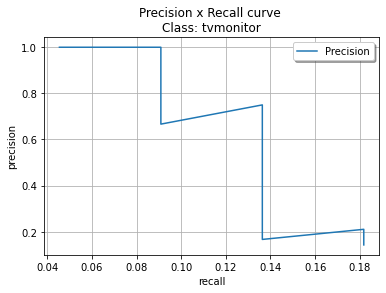

Average Precision:  0.13456937799043062


In [ ]:
# ["aeroplane", "bicycle", "bird", "boat", "bottle", 
#     "bus", "car", "cat", "chair", "cow", "diningtable", 
#     "dog", "horse", "motorbike", "person", "pottedplant", 
#     "sheep", "sofa", "train","tvmonitor"]

evaluator = evaluate.Evaluator()

for i in classes_name:
    ret = evaluator.PlotPrecisionRecallCurve(i, all_boudingBoxes[8])
    print('Average Precision: ', ret['AP'])

# Visualization

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

person
person


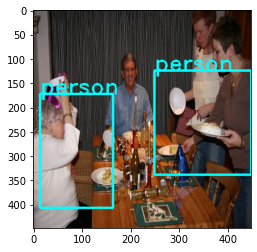

In [ ]:
np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000144.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = DenseNet121(np_img, training=False)
# -------------modify-------------
xmin, ymin, xmax, ymax, class_num, conf, num_of_pred_box = process_outputs(y_pred)
for i in range(num_of_pred_box):
    class_name = classes_name[class_num[i]]
    cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (int(xmin[i]), int(ymin[i])), 2, 1.5, (0, 255, 255), 2)
    print(class_name)
    # plt.imshow(resized_img)
    # plt.show()
# -------------modify-------------

plt.imshow(resized_img)
plt.show()

# Performance Analysis

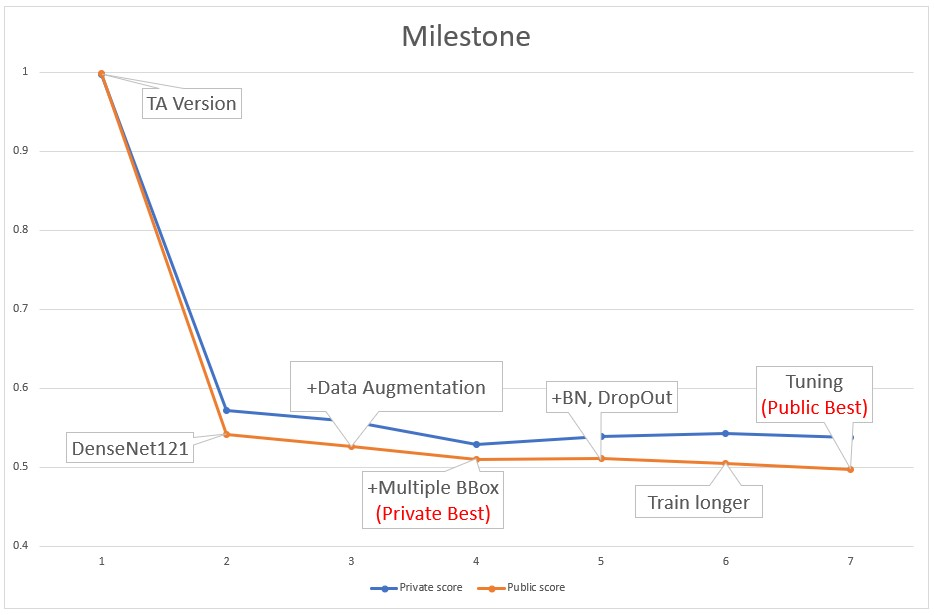

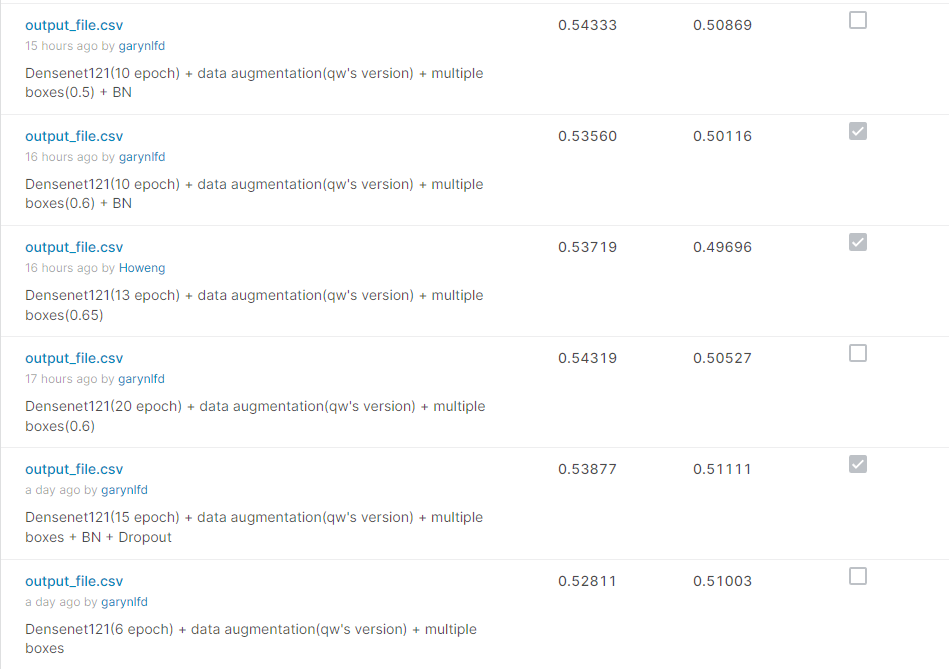

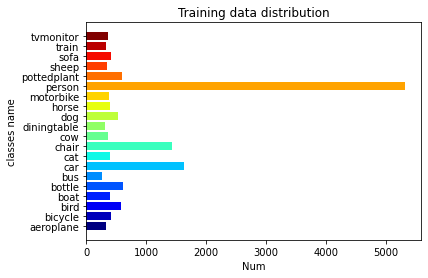

## Ablation Study

以上的圖是我們的`private leaderboard`的結果，和dataset中class sample的distribution

  * #### Data Augmentation
    - 首先對於data的分佈從上圖可以看出是相當不平均的，所以我們對其做了以下的四種改變： 
      - **HSV 值** (即色相、飽和度、明度)，**HorizontalFlip**，**scale**，**shear** 
      - 0.54182->0.52604
    - 從原本的5011張圖片，在augmentation完後共有26893張圖片。
    - 如下表所示，從`public score`來看，加了**aug**後表現從0.54182->0.52604，`private score`也從0.57163->0.55791，可見透過`augmentation`來平衡dataset是非常有效的。實際也讓我們後續的調整有更好的表現。
  
  
  || Public | Private |
  | :-: | :-: | :-: |
  |W/ Aug| 0.52604 | 0.55791 |
  |W/O Aug| 0.54182 | 0.57163 |

  * #### Multi-box with different threshold
    - 原本助教給的範例code是只有`single boundingBox`的結果，那是因為圖中讓模型只取最有信心的`boundingBox`。
    - 我們後續有對於`confidence score`究竟要用多少做了嘗試，最終認為基於我們的模型`threshold`設為
      - threshold = 0.6~0.65之間不等（最常用0.6）
      - 0.52604 -> 0.51727
    - 才能在有`multi object`的圖中出現複數且又不會出現太多亂框或者多餘的boundingBox。
  * #### Unfreeze Model layers & retrain weight
    - 除了直接換整個模型外，我們試著對`transfer learning`的pretrained模型做tuning。方法是對`DenseNet121`的最後一個block(第五個block)做layers的`unfreeze`並重新計算weight。
    - 這裡implement的方法是先使用freeze base model跑三個epochs，再unfreeze base model繼續跑三個epochs。 表現結果如下：
      - 0.52604 -> 0.67942
    - 可見，unfreeze並沒有帶給我們想要的進步效果。原因應該是只是單純看原本的loss做back propagation更新新的W是不夠的， 必須做類似YOLO那種不同layers的output結果都做衡量的複數loss為基礎，再更新W才會有比較好的效果。
  * #### DropOut  
    - 在`Conv_Leaky_ReLU`加入`DropOut`(0.2)，效果如下表
    - 可以看見在`public learderboard`上有實作DropOut的效果比沒有實作DropOut的效果來得差。但是在`private learderboard`上顯示加入了DropOut雖然一開始`MSE`表現會有點下降，但是下降的幅度是較小的。說明DropOut的確對於模型整體的泛化性起到了一定的作用。

    
  || Public | Private |
  | :-: | :-: | :-: |
  |W/ DropOut| 0.51111 | 0.53877 |
  |W/O DropOut| 0.50116 | 0.53560 |

  * #### BatchNormalization
   - 在`Conv_Leaky_ReLU`加入`BatchNormalization`，效果如下表
   - 可見在這裡不加BatchNormalization會比較好，但也許應該是BN會對完整的`YOLOv1`會有有效進展，但是對於我們的`DenseNet121`可能不適合。


  || Public | Private |
  | :-: | :-: | :-: |
  |W/ BN| 0.51111 | 0.53877 |
  |W/O BN| 0.49696 | 0.53719 |

  * #### Overall Result Conclusion
     上圖的`score board`顯示了幾個事實：
      - 加入`data_augmentation`有效
      - 加入`Dropout`有效
      - 不加`BatchNormalization`更有效
      - 選擇`Multiple boundingBox(th=0.6)`有效
      - 我們選擇的三個模型有點`overfit`，證據是DenseNet121(跑6個epochs）的模型在`private leaderboard`上擁有所有模型中最好的表現。


# Remark

- 以下連結為我們的model weight的檔案以及data augmentation所用到的.py檔
- 我們也有修改evaluate.py來觀察各個class的AP值, 也將evaluate資料夾一併附在以下連結中
https://drive.google.com/drive/folders/1AoK4V0vEt1VLA4ulINMjnw0iH3E_PS-n?usp=sharing
